<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\_utils\__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [3]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

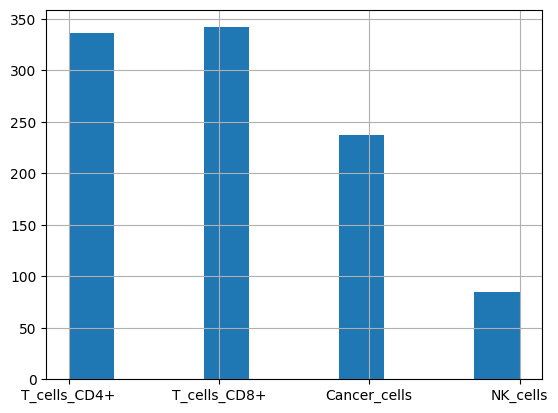

In [4]:
lab_df.label.hist();

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [5]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [6]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### EDA 

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [7]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

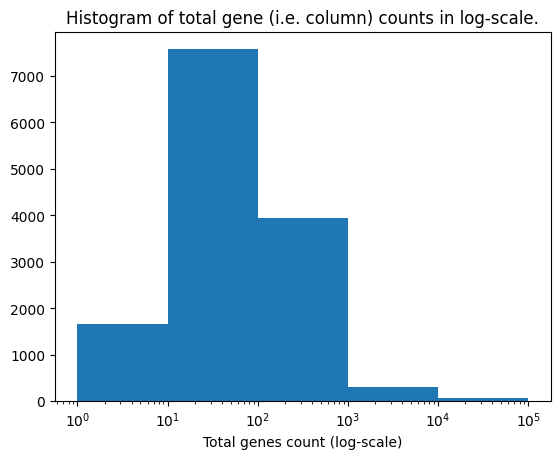

In [8]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

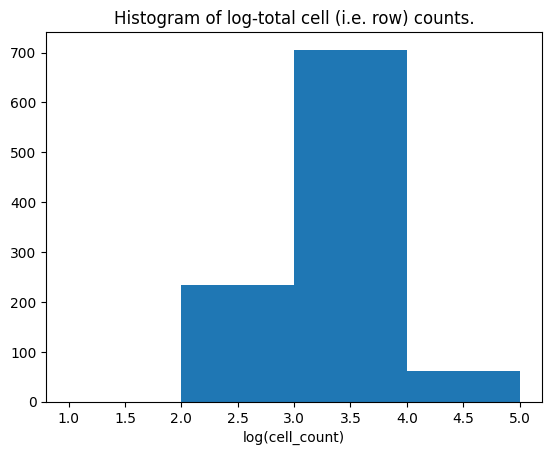

In [9]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [10]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

True

In [11]:
df_train = pd.DataFrame(
    preprocess_X(X_train),
    columns=[f"feature_{i}" for i in range(X_train.shape[1])]
)

df_train["target"] = y_train
df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13542,feature_13543,feature_13544,feature_13545,feature_13546,feature_13547,feature_13548,feature_13549,feature_13550,target
0,0.000071,0.0,0.0,0.000071,0.0,0.0,0.0,0.0,0.0,0.000071,...,0.0,0.000071,0.0,0.0,0.0,0.0,0.000212,0.000142,0.0,T_cells_CD4+
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,T_cells_CD4+
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.001530,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,T_cells_CD4+
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,T_cells_CD4+
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,T_cells_CD8+


- Séparation des target et valeurs de gènes (pour manipuler des matrices sparse après)

In [12]:
feature_cols = [c for c in df_train.columns if c.startswith("feature_")]
X_df = df_train[feature_cols]
y = df_train["target"].values

print("Shape X:", X_df.shape)
print("Nb classes:", len(np.unique(y)))


Shape X: (1000, 13551)
Nb classes: 4


- La proportions des valeurs nulles

In [13]:
from scipy import sparse
X = sparse.csr_matrix(X_df.values)

# Vérif rapide
print("X sparse:", type(X), "nnz:", X.nnz)
print("Sparsity global (% zeros):", 1 - X.nnz / (X.shape[0] * X.shape[1]))


X sparse: <class 'scipy.sparse._csr.csr_matrix'> nnz: 1091156
Sparsity global (% zeros): 0.919477824514796


- Calcul du library size

In [14]:
library_size = np.asarray(X.sum(axis=1)).ravel()
print(library_size)

[1.         1.0000001  1.         1.         1.0000001  0.99999994
 1.         1.         0.99999994 1.         1.         1.
 1.         0.99999994 1.0000001  1.         0.99999994 0.99999994
 0.9999999  1.         0.99999994 0.99999994 0.99999994 1.
 0.99999994 1.0000001  1.         1.         1.         1.
 1.         1.         1.         1.         1.0000001  1.
 1.         1.         1.         1.         0.99999994 1.0000001
 1.         1.0000001  1.         1.0000001  0.99999994 0.99999994
 1.         0.9999999  1.         1.         1.         1.
 0.99999994 0.99999994 1.         1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         0.99999994 0.99999994 1.         1.
 1.         1.0000001  1.         1.         1.0000001  1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999994 1.         0.9999999  1.         1.
 1.         0.99999994 0.99999994 1.         0.9999999  1.
 1.      

- Distribution de la variance (naive) des gènes

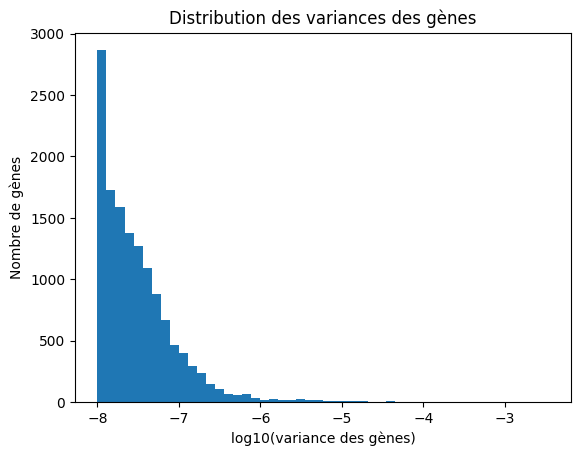

In [15]:
gene_matrix = df_train.drop(columns="target")
gene_variances = gene_matrix.var(axis=0)

top_genes = gene_variances.sort_values(ascending=False).head(10000)

plt.hist(np.log10(gene_variances + 1e-8), bins=50)
plt.xlabel("log10(variance des gènes)")
plt.ylabel("Nombre de gènes")
plt.title("Distribution des variances des gènes")
plt.show()


- Variance globale vs Dispersion

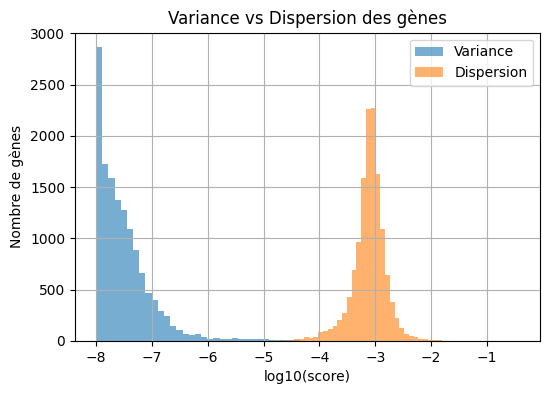

In [22]:
gene_means = gene_matrix.mean(axis=0)
gene_variances = gene_matrix.var(axis=0)

dispersion = gene_variances / (gene_means + 1e-8)
plt.figure(figsize=(6,4))
plt.hist(np.log10(gene_variances + 1e-8), bins=50, alpha=0.6, label="Variance")
plt.hist(np.log10(dispersion + 1e-8), bins=50, alpha=0.6, label="Dispersion")
plt.xlabel("log10(score)")
plt.ylabel("Nombre de gènes")
plt.title("Variance vs Dispersion des gènes")
plt.legend()
plt.grid(True)
plt.show()



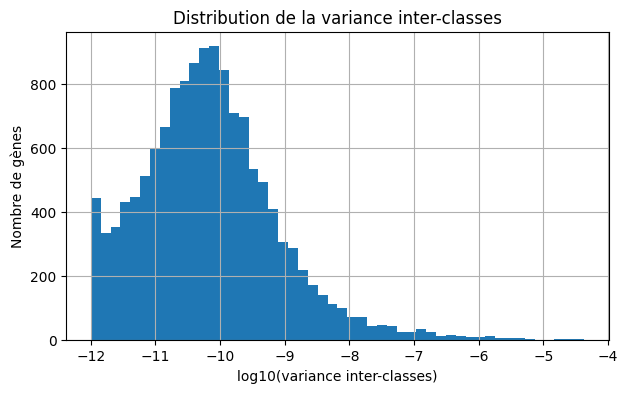

feature_1017     0.000042
feature_11841    0.000022
feature_6340     0.000016
feature_4854     0.000007
feature_4256     0.000006
feature_4257     0.000006
feature_5000     0.000005
feature_6981     0.000005
feature_9825     0.000004
feature_1829     0.000004
dtype: float64

In [ ]:
# Séparer X et y
feature_cols = [c for c in df_train.columns if c.startswith("feature_")]
X = df_train[feature_cols]
y = df_train["target"]

classes = np.unique(y)
n_total = len(y)

# Moyenne globale par gène
global_mean = X.mean(axis=0)

# Variance inter-classes
between_var = pd.Series(0.0, index=feature_cols)

for c in classes:
    Xc = X[y == c]
    nc = len(Xc)
    class_mean = Xc.mean(axis=0)
    between_var += nc * (class_mean - global_mean) ** 2

between_var /= n_total

# Top gènes selon variance inter-classes
top_genes_inter = between_var.sort_values(ascending=False).head(10000)

# Histogramme
plt.figure(figsize=(7,4))
plt.hist(np.log10(between_var + 1e-12), bins=50)
plt.xlabel("log10(variance inter-classes)")
plt.ylabel("Nombre de gènes")
plt.title("Distribution de la variance inter-classes")
plt.grid(True)
plt.show()

# Aperçu des meilleurs gènes
top_genes_inter.head(10)


- Approche anova : rapport variance inter-classes/ variance intra-classes

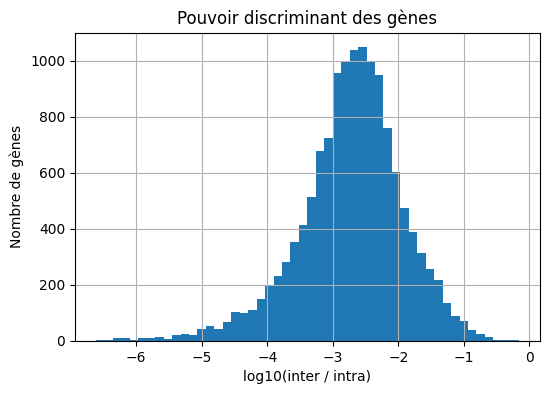

In [23]:
X = gene_matrix.values       
y = df_train["target"].values
classes = np.unique(y)

n, p = X.shape
overall_mean = X.mean(axis=0)

var_inter = np.zeros(p)
var_intra = np.zeros(p)

for c in classes:
    Xc = X[y == c]
    nk = Xc.shape[0]

    mean_c = Xc.mean(axis=0)
    var_c = Xc.var(axis=0)

    var_inter += nk * (mean_c - overall_mean) ** 2
    var_intra += nk * var_c

var_inter /= n
var_intra /= n
ratio = var_inter / (var_intra + 1e-8)

plt.figure(figsize=(6,4))
plt.hist(np.log10(ratio + 1e-8), bins=50)
plt.xlabel("log10(inter / intra)")
plt.ylabel("Nombre de gènes")
plt.title("Pouvoir discriminant des gènes")
plt.grid(True)
plt.show()


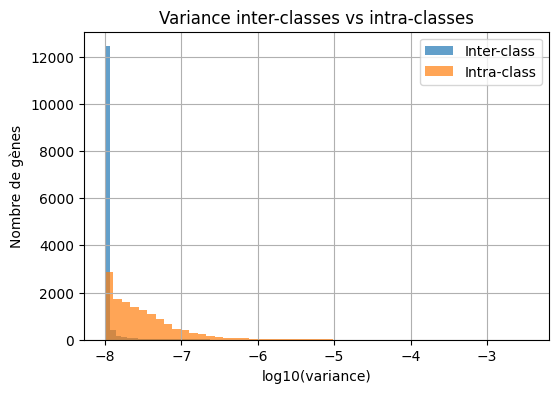

In [24]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(var_inter + 1e-8), bins=50, alpha=0.7, label="Inter-class")
plt.hist(np.log10(var_intra + 1e-8), bins=50, alpha=0.7, label="Intra-class")
plt.xlabel("log10(variance)")
plt.ylabel("Nombre de gènes")
plt.title("Variance inter-classes vs intra-classes")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import balanced_accuracy_score

In [19]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

In [20]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Random Forest: Mean Balanced Accuracy = 0.599
Gradient Boosting: Mean Balanced Accuracy = 0.637
Logistic Regression: Mean Balanced Accuracy = 0.648


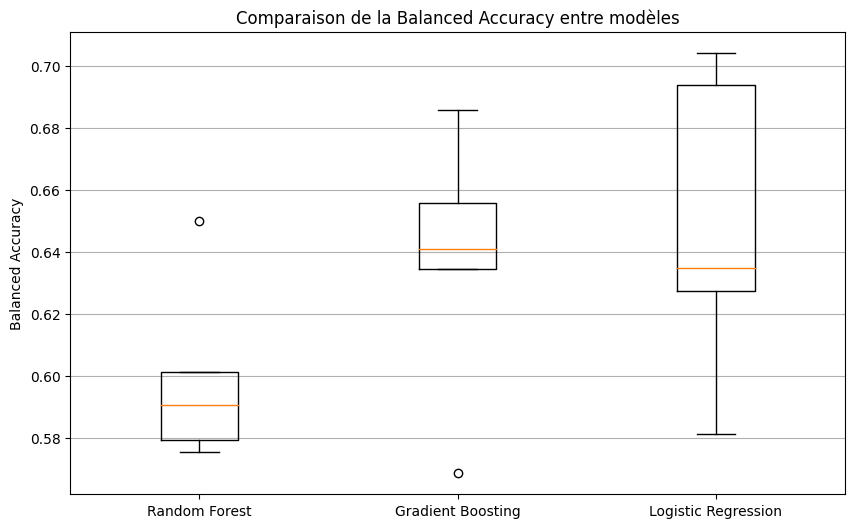

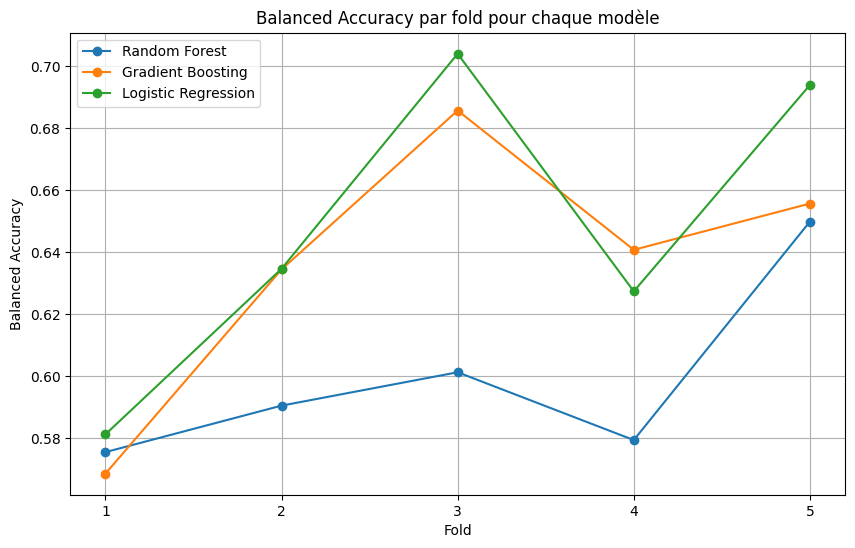

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

pipelines = {
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])
}


results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train.toarray(),  
        y_train,
        cv=5,
        scoring="balanced_accuracy"
    )
    results[name] = scores
    print(f"{name}: Mean Balanced Accuracy = {scores.mean():.3f}")


plt.figure(figsize=(10,6))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel("Balanced Accuracy")
plt.title("Comparaison de la Balanced Accuracy entre modèles")
plt.grid(axis="y")
plt.show()


plt.figure(figsize=(10,6))
for name, scores in results.items():
    plt.plot(range(1, len(scores)+1), scores, marker="o", label=name)

plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy par fold pour chaque modèle")
plt.xticks(range(1, len(scores)+1))
plt.legend()
plt.grid(True)
plt.show()


Random Forest: Mean Balanced Accuracy = 0.689
Gradient Boosting: Mean Balanced Accuracy = 0.773
Logistic Regression: Mean Balanced Accuracy = 0.816


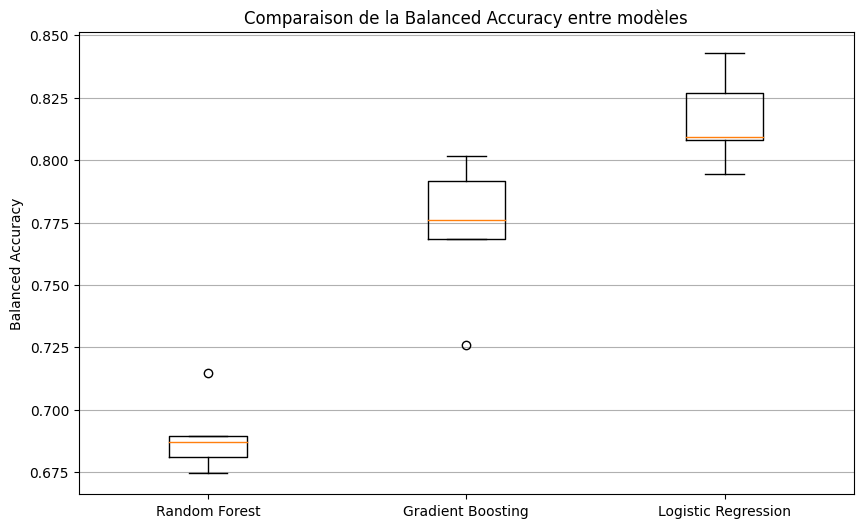

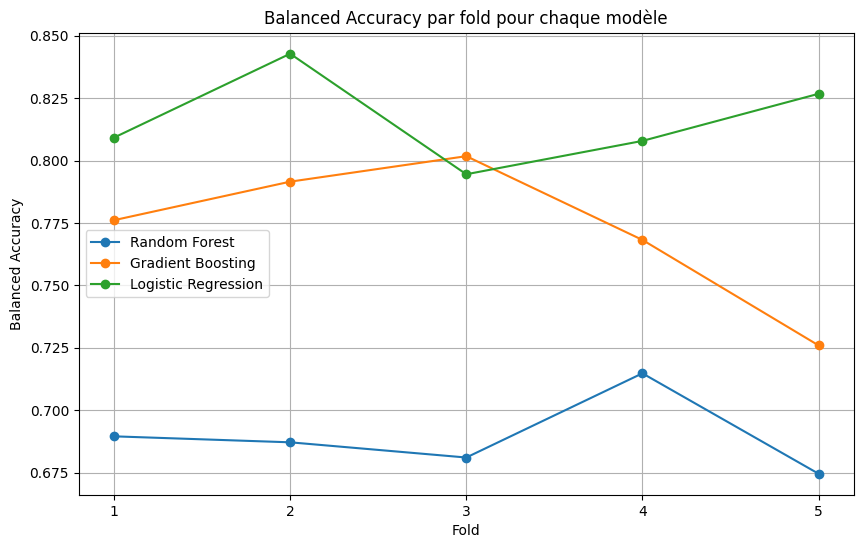

In [ ]:
gene_matrix = df_train.drop(columns="target")
gene_variances = gene_matrix.var(axis=0)


top_genes = gene_variances.sort_values(ascending=False).head(500)
top_gene_names = top_genes.index.tolist()


X_train_top = df_train[top_gene_names]
y_train = df_train["target"]


pipelines = {
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])
}


results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train_top.to_numpy(),  # Utiliser seulement les 1000 gènes sélectionnés
        y_train,
        cv=5,
        scoring="balanced_accuracy"
    )
    results[name] = scores
    print(f"{name}: Mean Balanced Accuracy = {scores.mean():.3f}")

plt.figure(figsize=(10,6))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel("Balanced Accuracy")
plt.title("Comparaison de la Balanced Accuracy entre modèles")
plt.grid(axis="y")
plt.show()


plt.figure(figsize=(10,6))
for name, scores in results.items():
    plt.plot(range(1, len(scores)+1), scores, marker="o", label=name)

plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy par fold pour chaque modèle")
plt.xticks(range(1, len(scores)+1))
plt.legend()
plt.grid(True)
plt.show()



Top 250 genes
  LogReg: 0.812
  RandomForest: 0.630
  GradientBoosting: 0.753

Top 500 genes
  LogReg: 0.830
  RandomForest: 0.689
  GradientBoosting: 0.779

Top 1000 genes
  LogReg: 0.817
  RandomForest: 0.673
  GradientBoosting: 0.773

Top 2000 genes
  LogReg: 0.803
  RandomForest: 0.635
  GradientBoosting: 0.723

Top 4000 genes
  LogReg: 0.753
  RandomForest: 0.599
  GradientBoosting: 0.708

Top 8000 genes
  LogReg: 0.743
  RandomForest: 0.595
  GradientBoosting: 0.692


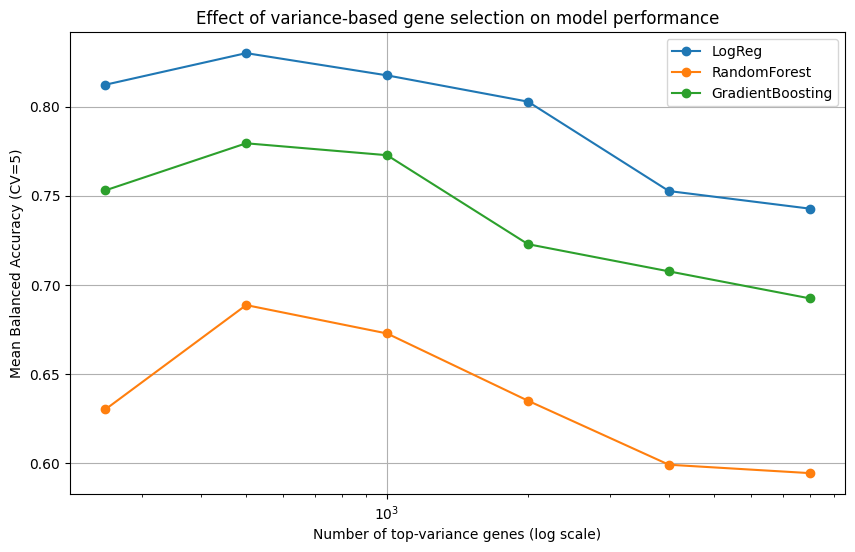

In [ ]:

# Variance globale (méthode naïve)
gene_variances = gene_matrix.var(axis=0).sort_values(ascending=False)

# Valeurs de top-k à tester
top_k_values = [250, 500, 1000, 2000, 4000, 8000]

# Modèles
pipelines = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=42
        ))
    ]),
    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            max_features=3,
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("clf", GradientBoostingClassifier(
            n_estimators=100,
            max_depth=3,
            random_state=42
        ))
    ])
}


results = {name: [] for name in pipelines}

for k in top_k_values:
    X_k = gene_matrix[gene_variances.head(k).index].to_numpy()
    print(f"\nTop {k} genes")

    for name, pipe in pipelines.items():
        scores = cross_val_score(
            pipe,
            X_k,
            y,
            cv=5,
            scoring="balanced_accuracy",
            n_jobs=-1
        )
        mean_score = scores.mean()
        results[name].append(mean_score)
        print(f"  {name}: {mean_score:.3f}")

plt.figure(figsize=(10,6))
for name, scores in results.items():
    plt.plot(top_k_values, scores, marker="o", label=name)

plt.xscale("log")
plt.xlabel("Number of top-variance genes (log scale)")
plt.ylabel("Mean Balanced Accuracy (CV=5)")
plt.title("Effect of variance-based gene selection on model performance")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#    log1p + variance normalisée (dispersion)

gene_matrix = df_train.drop(columns="target")

# log1p (important)
gene_matrix_log = np.log1p(gene_matrix)

# mean / var
gene_means = gene_matrix_log.mean(axis=0)
gene_vars  = gene_matrix_log.var(axis=0)

# dispersion
dispersion = gene_vars / (gene_means + 1e-6)

# pré-filtrage large (on ne coupe PAS trop tôt)
pre_k = 3000     # important : large
top_genes = dispersion.sort_values(ascending=False).head(pre_k)
top_gene_names = top_genes.index.tolist()

X_pre = gene_matrix_log[top_gene_names].to_numpy()
y = df_train["target"].values

l1_selector = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=0.3,                  
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

l1_selector.fit(X_pre, y)

coef = l1_selector.named_steps["clf"].coef_
mask_l1 = np.any(coef != 0, axis=0)

print(f"Nombre de gènes gardés par L1 : {mask_l1.sum()}")

X_l1 = X_pre[:, mask_l1]


# Modèle final (L2)


final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(
        n_components=min(50, X_l1.shape[1] - 1),
        random_state=42
    )),
    ("clf", LogisticRegression(
        penalty="l2",
        C=3.0,
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])



scores = cross_val_score(
    final_pipe,
    X_l1,
    y,
    cv=5,
    scoring="balanced_accuracy"
)

print(f"LogReg L1+L2 : Mean Balanced Accuracy = {scores.mean():.3f} (+/- {scores.std():.3f})")

plt.figure(figsize=(6,4))
plt.boxplot([scores], labels=["L1 + L2"])
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy (CV=5)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(scores)+1), scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy par fold (L1 + L2)")
plt.xticks(range(1, len(scores)+1))
plt.grid(True)
plt.show()


Logistic Regression: Mean Balanced Accuracy = 0.774 (+/- 0.020)


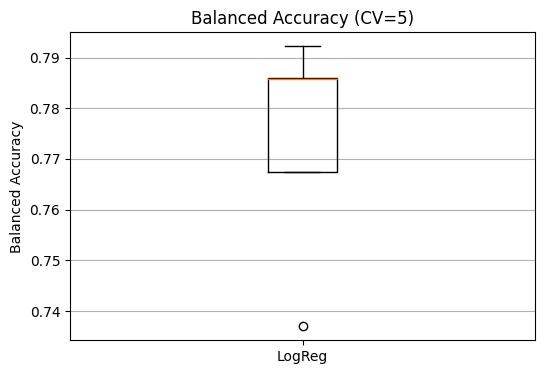

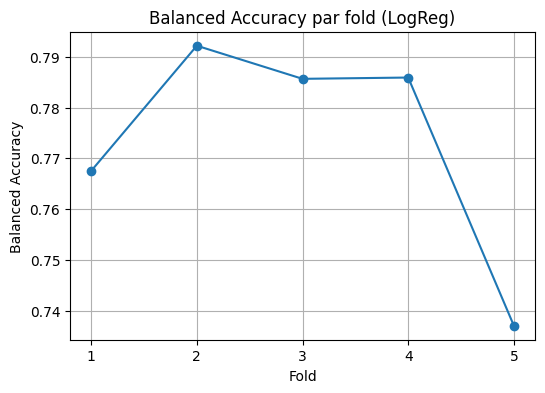

In [ ]:
# log1p (classique scRNA / counts)
gene_matrix_log = np.log1p(gene_matrix)

# mean/var par gène
gene_means = gene_matrix_log.mean(axis=0)
gene_vars  = gene_matrix_log.var(axis=0)

# dispersion 
dispersion = gene_vars / (gene_means + 1e-6)

# top-k gènes selon dispersion
top_k = 500   # <-- à tester: 1000 / 1500 / 2000
top_genes = dispersion.sort_values(ascending=False).head(top_k)
top_gene_names = top_genes.index.tolist()

# dataset final
X_train_top = gene_matrix_log[top_gene_names]  # on garde log1p
y_train = df_train["target"].values


pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=50, random_state=42)),  
    ("clf", LogisticRegression(
        max_iter=4000,
        C=10.0,                    
        class_weight="balanced",  
        random_state=42
    ))
])


scores = cross_val_score(
    pipe,
    X_train_top.to_numpy(),
    y_train,
    cv=5,
    scoring="balanced_accuracy"
)

print(f"Logistic Regression: Mean Balanced Accuracy = {scores.mean():.3f} (+/- {scores.std():.3f})")

# Boxplot (1 modèle -> pas indispensable, mais je te le laisse)
plt.figure(figsize=(6,4))
plt.boxplot([scores], labels=["LogReg"])
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy (CV=5)")
plt.grid(axis="y")
plt.show()

# Scores par fold
plt.figure(figsize=(6,4))
plt.plot(range(1, len(scores)+1), scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy par fold (LogReg)")
plt.xticks(range(1, len(scores)+1))
plt.grid(True)
plt.show()
